<a href="https://colab.research.google.com/github/Gourdji19/Infogan_Mnist_pytorch/blob/main/Infogan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Apr 19 20:13:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
!{sys.executable} -m pip install easydict

In [ ]:
!{sys.executable} -m pip install ipywidgets

In [ ]:
!{sys.executable} -m pip install widgetsnbextension

In [ ]:
import os
import argparse
import warnings
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm
import easydict

In [ ]:
class Generator(nn.Module):
    """Generator structure from InfoGAN paper"""
    def __init__(self,latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.fc1 = nn.Sequential(
            nn.Linear(self.latent_dim,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024,7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(),
        )
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=4,stride=2,padding=1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(x.shape[0],128,7,7)
        x = self.upconv1(x)
        x = self.upconv2(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    """Discriminator structure from InfoGAN paper"""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(0.1),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(128*5*5,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.shape[0],128*5*5)
        fe_out = self.fc1(x)
        y = self.fc2(fe_out)
        return y,fe_out

In [ ]:
class Qnet_Categorical(nn.Module):
    """Q-part of network from InfoGAN paper"""
    def __init__(self,n_cat):
        super(Qnet_Categorical, self).__init__()
        self.n_cat = n_cat
        self.fcQ = nn.Sequential(
            nn.Linear(1024,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128,self.n_cat)
        )
    def forward(self,x):
        y_logits = self.fcQ(x)
        return y_logits

In [ ]:
class InfoGAN_MNIST:
    def __init__(self,args,n_latent,n_cat):
        self.batch_size = args.batch_size
        self.num_epochs = args.epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.n_noise = n_latent
        self.n_cat = n_cat
        self.n_latent = n_latent+n_cat
        self.cat_prob = torch.ones(n_cat)*0.1
        self.generator = Generator(self.n_latent).to(self.device)
        self.discriminator = Discriminator().to(self.device)
        self.qnet = Qnet_Categorical(self.n_cat).to(self.device)
        self.dset_train = MNIST("./", train=True, download=True, transform=transforms.ToTensor())
        self.train_loader = DataLoader(self.dset_train, batch_size=self.batch_size,shuffle=True,
                                    pin_memory=torch.cuda.is_available(),drop_last=True)
        self.dset_test  = MNIST("./", train=False, download=True, transform=transforms.ToTensor())
        self.test_loader  = DataLoader(self.dset_test, batch_size=self.batch_size, shuffle=False,
                                    pin_memory=torch.cuda.is_available(),drop_last=True)
    def train(self):
        self.generator.train()
        self.discriminator.train()
        self.qnet.train()

        K = 3
        lambda_cat = 1
        bce_loss = nn.BCELoss()
        CE_loss = nn.CrossEntropyLoss()
        optimG = torch.optim.Adam(list(self.generator.parameters())+list(self.qnet.parameters()),lr=1e-3,betas=(0.5, 0.99))
        optimD = torch.optim.Adam(self.discriminator.parameters(),lr=2e-4,betas=(0.5, 0.99))

        batch_size = self.batch_size
        true_label = torch.ones(batch_size, 1).to(self.device)
        fake_label = torch.zeros(batch_size, 1).to(self.device)
        best_test_acc = 0
        loss_d_arr, loss_g_arr = [], []
        for epoch in range(self.num_epochs):
            with tqdm(total=len(self.train_loader)) as pbar:
                pbar.set_description("Epoch {}".format(epoch))
                for batch_nr, (img_true, _) in enumerate(self.train_loader):
                    optimG.zero_grad()
                    optimD.zero_grad()

                    noise_vector = torch.randn(batch_size, self.n_noise).to(self.device)
                    cat_vector = torch.multinomial(self.cat_prob,batch_size,replacement=True)
                    cat_one_hot = torch.zeros(batch_size,self.n_cat)
                    cat_one_hot[range(batch_size),cat_vector] = 1
                    cat_one_hot = cat_one_hot.to(self.device)

                    img_fake_input = torch.cat((noise_vector,cat_one_hot),dim=1)
                    img_fake = self.generator(img_fake_input)
                    y_fake,_ = self.discriminator(img_fake.detach())
                    y_true,_ = self.discriminator(img_true.to(self.device))
                    loss_D = bce_loss(y_true, true_label) + bce_loss(y_fake, fake_label)
                    loss_d_arr.append(loss_D.cpu().detach().numpy())
                    loss_D.backward()
                    optimD.step()

                    y_fake,fe_out = self.discriminator(img_fake)
                    y_cat_logits = self.qnet(fe_out)
                    cat_target = cat_vector.long().to(self.device)
                    loss_Q = lambda_cat*CE_loss(y_cat_logits,cat_target)
                    loss_G = bce_loss(y_fake, true_label) + loss_Q
                    loss_G.backward(retain_graph=True)
                    loss_g_arr.append(loss_G.cpu().detach().numpy())
                    optimG.step()

                    pbar.update()

            test_acc = self.eval()
            self.generator.train()
            self.discriminator.train()
            self.qnet.train()

            if test_acc>best_test_acc:
                torch.save(self.generator.state_dict(),"generator_weights.pth")
                torch.save(self.discriminator.state_dict(),"discriminator_weights.pth")
                torch.save(self.qnet.state_dict(),"qnet_weights.pth")
                best_test_acc = test_acc
        return loss_d_arr, loss_g_arr
      
    def eval(self):
        self.generator.eval()
        self.discriminator.eval()
        self.qnet.eval()
        

        exemplar_idx = [68, 6, 76, 7, 20, 259, 66, 263, 265, 264]
        exemplars = []
        for idx in exemplar_idx:
            img,img_lbl = self.dset_train.__getitem__(idx)
            exemplars.append(img)
        exemplar_batch = torch.cat(exemplars,dim=0).unsqueeze(1).to(self.device)

        with torch.no_grad():
            _,fe_out = self.discriminator(exemplar_batch)
            y_cat = self.qnet(fe_out)
        exemplar_cat = torch.argmax(torch.softmax(y_cat,dim=1),dim=1)
        exemplar_cat = exemplar_cat.cpu().numpy()
        cat2class = {cat:cls for cls,cat in enumerate(exemplar_cat)}
        if len(cat2class.keys())!=10:
            warn_str = """Only {}/10 classes identified from exemplars. Some classes might be mixed.
            Consider retraining the network if this is the final iteration.""".format(len(cat2class.keys()))
            warnings.warn(warn_str)

        running_sum = 0
        with tqdm(total=len(self.test_loader)) as pbar:
            pbar.set_description("Test loss")
            for (test_imgs,test_labels) in self.test_loader:
                with torch.no_grad():
                    _,fe_out = self.discriminator(test_imgs.to(self.device))
                    y_cat = self.qnet(fe_out)
                test_cat = torch.argmax(torch.softmax(y_cat,dim=1),dim=1)
                test_cat = test_cat.cpu().numpy()
                test_pred_class = np.array([cat2class[cat] if cat in cat2class.keys() else np.nan for cat in test_cat])
                running_sum+=sum(test_pred_class==test_labels.numpy())
                pbar.update()
            test_accuracy = running_sum/len(self.dset_test)
            pbar.set_postfix({'test_acc':test_accuracy})
        return test_accuracy

In [ ]:
args = easydict.EasyDict({
    "batch_size": 64,
    "epochs": 2
    })
info_gan = InfoGAN_MNIST(args,n_latent=64,n_cat=10)
loss_d_arr, loss_g_arr = info_gan.train()


Epoch 0: 100%|██████████| 937/937 [00:15<00:00, 61.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: UserWarning: Only 7/10 classes identified from exemplars. Some classes might be mixed.
            Consider retraining the network if this is the final iteration.
Epoch 1: 100%|██████████| 937/937 [00:15<00:00, 62.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: UserWarning: Only 8/10 classes identified from exemplars. Some classes might be mixed.
            Consider retraining the network if this is the final iteration.
Test loss: 100%|██████████| 156/156 [00:00<00:00, 196.18it/s, test_acc=0.536]


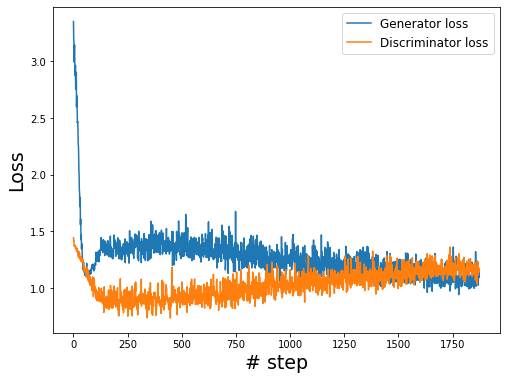

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(loss_g_arr)), loss_g_arr, label="Generator loss")
ax.plot(range(len(loss_d_arr)), loss_d_arr, label="Discriminator loss")
ax.set_xlabel('# step', fontsize=19)
ax.set_ylabel('Loss', fontsize=19)
plt.legend(fontsize=12)

In [ ]:
# generate input for generator (since we need to do some experiments with it)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64
n_cat = 10
cat_prob = torch.ones(n_cat)*0.1

noise_vector = torch.randn(batch_size, 64).to(device)
cat_vector = torch.multinomial(cat_prob, batch_size,replacement=True)
cat_one_hot = torch.zeros(batch_size, n_cat)
cat_one_hot[range(batch_size),cat_vector] = 1
cat_one_hot = cat_one_hot.to(device)
input_ = torch.cat((noise_vector,cat_one_hot),dim=1)
print(input_.cpu().numpy().shape)

(64, 74)


In [ ]:
info_index = 64
img_index = 3
img_fakes = []
with torch.no_grad():
  for i in range(3):
    input_2 = input_
    input_2[:, info_index + i] = 1
    img_fakes.append(info_gan.generator(input_2).cpu().numpy()[img_index][0])

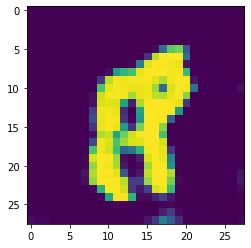

In [ ]:
plt.imshow(img_fakes[0])

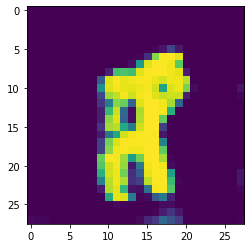

In [ ]:
plt.imshow(img_fakes[2])

In [ ]:
input_[0, 64:]

tensor([1., 1., 1., 0., 0., 0., 1., 1., 1., 1.], device='cuda:0')

In [ ]:
input_[0, 0:20]

tensor([ 1.0000,  1.0000,  1.0000, -0.8017, -0.0107, -0.1338,  0.8818,  0.6427,
         0.4803, -0.8138, -0.4703, -1.6551,  0.3854,  0.7831,  0.0182,  2.4429,
         0.5188, -0.2503,  2.5885, -0.8219], device='cuda:0')